<a href="https://colab.research.google.com/github/jonDuke/DBSCAN-implementation/blob/master/DBSCAN_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating some sample data

In [ ]:
from sklearn.datasets.samples_generator import make_blobs, make_moons
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
blobs_X, blobs_y = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=2, random_state=42)
blobs_X[:5]

array([[-8.57321463, -9.90980404],
       [ 6.26691327, -0.48855895],
       [-3.44814639, 10.09940622],
       [ 7.44546746, -0.83053244],
       [-6.16405247, -5.75854054]])

In [ ]:
# y is the true lable, or which blob it belongs to
blobs_y[:5]

array([2, 1, 0, 1, 2])

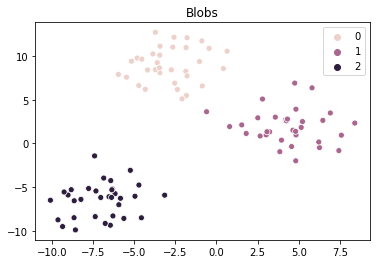

In [ ]:
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=blobs_y)
plt.title("Blobs")
plt.show()

In [ ]:
# Different shape
moons_X, moons_y = make_moons(n_samples=250, noise=.1, random_state=42)
moons_X[:5]

array([[ 0.07698099,  0.14419139],
       [ 1.11336239,  0.15799269],
       [-0.65809489,  0.71927374],
       [ 0.07121418,  0.85436817],
       [-1.05691034,  0.37348719]])

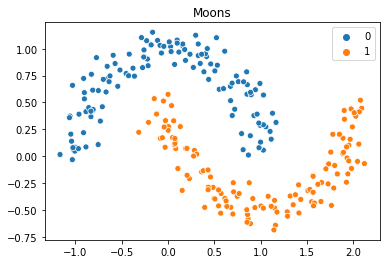

In [ ]:
# Moons are not linearly separable
sns.scatterplot(moons_X[:,0], moons_X[:,1], hue=moons_y)
plt.title("Moons")
plt.show()

# Demonstrating SKlearn's DBSCAN implementation

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
%%time
# eps is the distance to check for neighbors
# min_samples is the number of neighbors required to be a core point
sklearn_clusters = DBSCAN(eps=2, min_samples=5).fit(blobs_X)

CPU times: user 2.81 ms, sys: 0 ns, total: 2.81 ms
Wall time: 3.2 ms


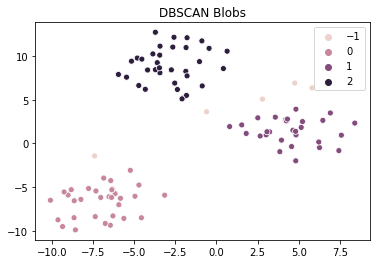

In [ ]:
# Same graph as before, but with SKlearn's DBSCAN labels
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=sklearn_clusters.labels_)
plt.title("DBSCAN Blobs")
plt.show()

In [ ]:
%%time
sklearn_clusters2 = DBSCAN(eps=.25, min_samples=5).fit(moons_X)

CPU times: user 3.32 ms, sys: 0 ns, total: 3.32 ms
Wall time: 4.18 ms


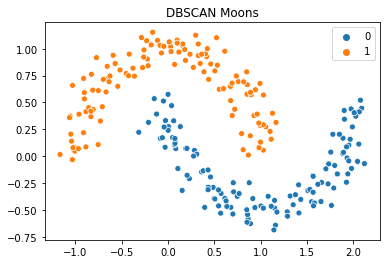

In [ ]:
# Same graph as before, but with SKlearn's DBSCAN labels
sns.scatterplot(moons_X[:,0], moons_X[:,1], hue=sklearn_clusters2.labels_)
plt.title("DBSCAN Moons")
plt.show()

# Writing my own implementation

In [ ]:
import math

# Default distance function I will use, euclidean distance
def EuclideanDistance(point1, point2):
  """ 
  Returns the Euclidean distance between two points
  
  Assumes points are a list of coordinate values, works with any number
  of dimensions
  """
  sum = 0
  for i in range(len(point1)):
    sum += (point2[i] - point1[i]) ** 2
  return math.sqrt(sum)

In [ ]:
# DBSCAN uses a helper function that returns all points within a certain
# distance of a given point
def RangeQuery(collection, point, distFunc, eps):
  """
  Finds all points in collection within eps distance of point.

  Returns a list of index values indicating those points in collection.

  Arguments:
    collection (iterable): a list of points
    point (iterable): a point, represented as a list of coordinates
    distFunc (callable): the distance function to use
    eps (float): epsilon, the maximum distance to include points at
  """
  neighbors = []
  for i in range(len(collection)):
    if distFunc(collection[i], point) < eps:
      neighbors.append(i)
  
  return neighbors

In [ ]:
# Main DBSCAN function
def my_DBSCAN(X, eps, minPts, distFunc="euclidean"):
  """
  Density based clustering, returns a list of labels assigning each point to a
  cluster.  Clusters will be labeled 0 and up, while outlier points will be
  labeled with -1.

  Arguments:
    X (iterable): the collection of points

    eps (float): epsilon, the distance for points to be considered close to 
                 each other

    minPts (int): the number of points that must be within epsilon distance for 
                  a point to be considered a core point

    distFunc (callable): the distance function to use, defaults to Euclidean 
                         distance
  """
  if distFunc == "euclidean":
    distFunc = EuclideanDistance

  labels = [None] * len(X)  # start with all labels undefined
  cluster = 0  # cluster counter

  for i in range(len(X)):
    if labels[i] is not None:
      # This point has already been found as a neighbor, skip it
      continue
    
    # Find all points within eps distance to this point
    neighbors = RangeQuery(X, X[i], distFunc, eps)

    if len(neighbors) < minPts:
      # not enough connected points, i is not a core point
      labels[i] = -1
      continue
    
    # this point is in a cluster
    labels[i] = cluster

    # since i is a core point, all neighbors are in this cluster
    # find those neighbors, and if they are also core points add their neighbors too
    j = 0
    while j < len(neighbors):
      p = neighbors[j]  # get this point's index
      if labels[p] == -1:
        # assign outlier to this cluster (border point)
        labels[p] = cluster
      
      if labels[p] is not None:
        # point has already been found, skip it
        j += 1
        continue
      
      # assign this point to the cluster and find its neighbors
      labels[p] = cluster
      new_neighbors = RangeQuery(X, X[p], distFunc, eps)
      if len(new_neighbors) >= minPts:
        # j is also a core point, add its neighbors to the list to consider
        # add each neighbor that isn't already in the list, preserve list order
        for n in new_neighbors:
          if n not in neighbors:
            neighbors.append(n)
      
      j += 1  # move to next point
    
    cluster += 1  # increment cluster counter
  
  return labels

# Testing my implementation

## Blobs

In [ ]:
%%time
# Use my function
clusters = my_DBSCAN(blobs_X, eps=2, minPts=5)

print(clusters)

[0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, -1, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 1, -1, 0, -1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 2, 0, 2, 2, 2, -1, 2, 1, 1, 1, 2, -1, 2, 2, 2, 1, 0, 2]
CPU times: user 29.8 ms, sys: 964 µs, total: 30.7 ms
Wall time: 31.3 ms


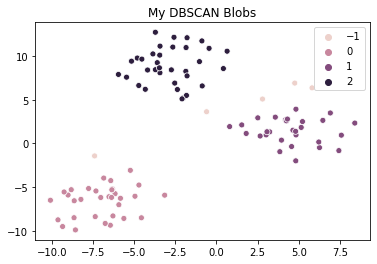

In [ ]:
# My clusters
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=clusters)
plt.title("My DBSCAN Blobs")
plt.show()

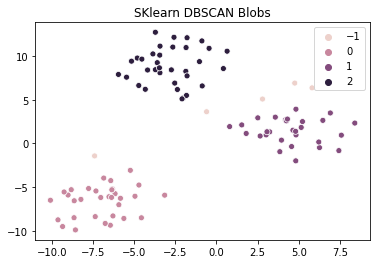

In [ ]:
# SKLearn clusters
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=sklearn_clusters.labels_)
plt.title("SKlearn DBSCAN Blobs")
plt.show()

## Moons

In [ ]:
%%time
# Use my function
clusters2 = my_DBSCAN(moons_X, eps=.25, minPts=5)

CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 166 ms


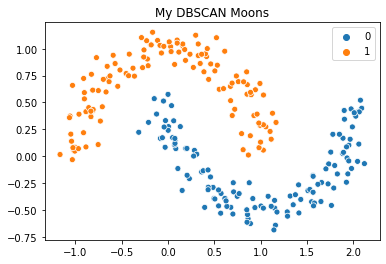

In [ ]:
# Same graph as before, but with SKlearn's DBSCAN labels
sns.scatterplot(moons_X[:,0], moons_X[:,1], hue=clusters2)
plt.title("My DBSCAN Moons")
plt.show()

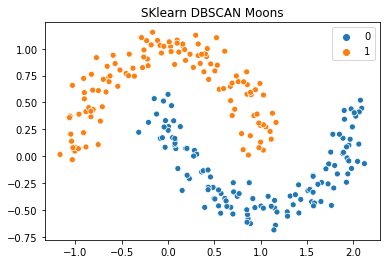

In [ ]:
# Same graph as before, but with SKlearn's DBSCAN labels
sns.scatterplot(moons_X[:,0], moons_X[:,1], hue=sklearn_clusters2.labels_)
plt.title("SKlearn DBSCAN Moons")
plt.show()

# Creating a class

The end goal is to create a class with the same fit and predict methods as SKlearn.

I am also doing this as a separate section of code because I am adding an optimization to it, using SciPy.

Note: while the project instructions said the class should have `fit` and `predict` methods, SKlearn's DBSCAN does not have a `predict` because it is not needed for this algorithm.

In [ ]:
# pdist helps find differences between each pair of points very quickly
# squareform helps make the result more readable
# pdist also handles the euclidean distance definition
from scipy.spatial.distance import pdist, squareform


def FindNeighbors(dist_matrix, eps, point_index):
    """
    Helper function to find all neighbors to the given point within distance
    eps, using a distance matrix
    """
    neighbors = []
    # iterate over the appropriate row of the distance matrix
    for i in range(dist_matrix.shape[1]):
        if dist_matrix[point_index][i] <= eps:
            # if the point was close enough, add its index to the list
            neighbors.append(i)
    return neighbors


class MyDBSCAN:
    """
    My implementation of DBSCAN, behaves similarly to the SKlearn version

    Define epsilon and min points with __init__(), and use fit() to run the
    clustering algorithm.  Access those clusters with labels_.
    """

    def __init__(self, eps=.5, minPts=5, distFunc='euclidean'):
        """
        Initialize self.

        Arguments:
            eps (float): Epsilon, the maximum distance between two samples for
                         them to be considered neighbors.  It is important to
                         choose an appropriate value for your data set and
                         distance function.
            
            minPts (int): The minimum number of points in a neighborhood for
                          a point to be considered a core point.
            
            distFunc (callable): The function used to determine distance between
                                 two points.  Defaults to euclidean distance.
        """
        self.eps = eps
        self.minPts = minPts

        if distFunc == 'euclidean':
            self.distFunc = EuclideanDistance
        else:
            self.distFunc = distFunc
        
        self.labels_ = []
    
    def fit_predict(self, X):
        """
        Performs DBSCAN clustering on the feature collection X and returns the
        cluster labels
        """
        self.fit(X)
        return self.labels_
    
    def fit(self, X):
        """
        Performs DBSCAN clustering on the feature collection X
        """
        # Use scipy to pre-calculate distances between each pair of points
        dist_matrix = squareform(pdist(X, metric=self.distFunc))

        # Initialize cluster counter and labels array
        self.labels_ = [None] * len(X)
        cluster = 0

        for i in range(len(X)):
            if self.labels_[i] is not None:
                continue  # This point has already been assigned to a cluster
            
            # Find all points within eps distance to this point
            neighbors = FindNeighbors(dist_matrix, self.eps, i)

            if len(neighbors) < self.minPts:
                # not enough neighbors, i is not a core point
                self.labels_[i] = -1
                continue
            
            # If this is reached, i is a core point
            self.labels_[i] = cluster

            # Iterate through neighbors in this cluster, if a point is also a
            # core point then its neighbors are added too
            j = 0
            while j < len(neighbors):
                p = neighbors[j]  # this neighbor's index
                if self.labels_[p] == -1:
                    # this point was previously marked as an outlier, but
                    # is a border point of this cluster
                    self.labels_[p] = cluster
                
                if self.labels_[p] is not None:
                    # this point has already been checked, skip it
                    j += 1
                    continue
                
                # assign this point to the cluster and find its neighbors
                self.labels_[p] = cluster
                new_neighbors = FindNeighbors(dist_matrix, self.eps, p)
                if len(new_neighbors) >= self.minPts:
                    # p is also a core point, add its neighbors to the list
                    # add each neighbor not already in the list, preserve order
                    for n in new_neighbors:
                        if n not in neighbors:
                            neighbors.append(n)
            
                j += 1  # move to next point
            
            # increment cluster counter since we are done identifying this one
            cluster += 1
        
        return self  # return self to remain consistent with SKlearn behavior


# Using the class

## Blobs time

n=100

In [ ]:
%%time
# the class implementation, with the SciPy function
myDB = MyDBSCAN(eps=2, minPts=5).fit(blobs_X)

CPU times: user 21.6 ms, sys: 806 µs, total: 22.4 ms
Wall time: 22.5 ms


In [ ]:
%%time
# my original implementation
clusters = my_DBSCAN(blobs_X, eps=2, minPts=5)

CPU times: user 30.6 ms, sys: 0 ns, total: 30.6 ms
Wall time: 32.3 ms


In [ ]:
%%time
# SKlearn's time
sklearn_clusters = DBSCAN(eps=2, min_samples=5).fit(blobs_X)

CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 2.22 ms


## Moons time

n=250

In [ ]:
%%time
# the class implementation, with the SciPy function
myDB = MyDBSCAN(eps=.25, minPts=5).fit(moons_X)

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 129 ms


In [ ]:
%%time
# my original implementation
clusters2 = my_DBSCAN(moons_X, eps=.25, minPts=5)

CPU times: user 160 ms, sys: 1 ms, total: 161 ms
Wall time: 163 ms


In [ ]:
%%time
# SKlearn's time
sklearn_clusters2 = DBSCAN(eps=.25, min_samples=5).fit(moons_X)

CPU times: user 3.06 ms, sys: 0 ns, total: 3.06 ms
Wall time: 3.4 ms


# Graphical Comparison

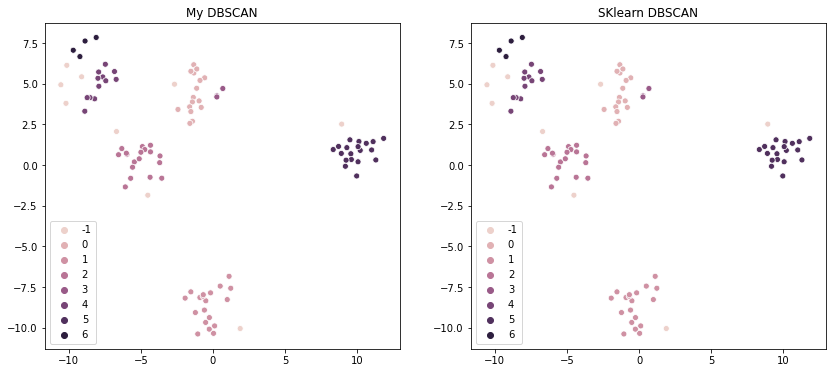

In [ ]:
# Create new sample data if desired
test_X, test_y = make_blobs(n_samples=100, centers=5, n_features=2, 
                            cluster_std=1, random_state=7)

# Perform clustering
eps = 1
minPts = 3
myDB = MyDBSCAN(eps=eps, minPts=minPts).fit(test_X)
skDB = DBSCAN(eps=eps, min_samples=minPts).fit(test_X)

# Set up sub-plots for side-by-side comparison
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14,6)

sns.scatterplot(test_X[:,0], test_X[:,1], hue=myDB.labels_, ax=ax[0], legend='full')
ax[0].set_title("My DBSCAN")

sns.scatterplot(test_X[:,0], test_X[:,1], hue=skDB.labels_, ax=ax[1], legend='full')
ax[1].set_title("SKlearn DBSCAN")

plt.show()

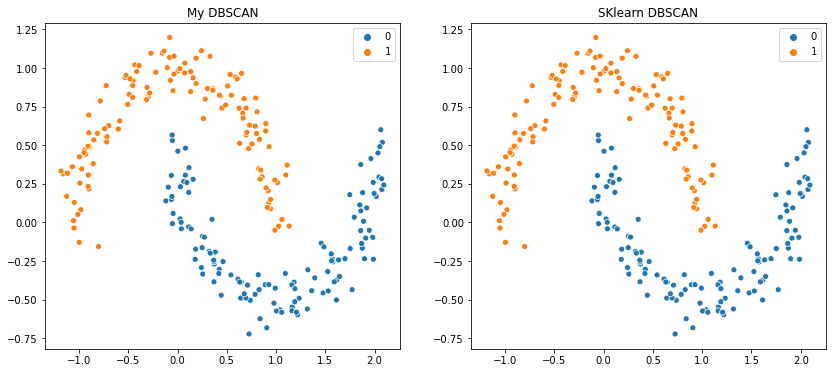

In [ ]:
# Create new sample data if desired
test_X, test_y = make_moons(n_samples=250, noise=.1, random_state=7)

# Perform clustering
eps = .25
minPts = 5
myDB = MyDBSCAN(eps=eps, minPts=minPts).fit(test_X)
skDB = DBSCAN(eps=eps, min_samples=minPts).fit(test_X)

# Set up sub-plots for side-by-side comparison
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14,6)

sns.scatterplot(test_X[:,0], test_X[:,1], hue=myDB.labels_, ax=ax[0])
ax[0].set_title("My DBSCAN")

sns.scatterplot(test_X[:,0], test_X[:,1], hue=skDB.labels_, ax=ax[1])
ax[1].set_title("SKlearn DBSCAN")

plt.show()